# Regularization Proje

Regularization Tekniklerini anlamak için House Prices data seti üzerinde bir proje yapacağız.

https://www.kaggle.com/c/house-prices-advanced-regression-techniques

Önce sıradan bir OLS modeli kuracağız (içinde Regularizasyon olmayan).

Ardından modelimize Regularizasyon Cezaları (Ridge ve Lasso) ekleyerek onu iyileştireceğiz.

## Data Yükleme

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import warnings

# warning'ler
warnings.filterwarnings("ignore")

# seaborn default set işlemi
sns.set()

# notebook için 'png' set işlemi
%config InlineBackend.figure_format = 'png' 
%matplotlib inline

# data setlerin yolları
trainData = 'data/train.csv'
testData = 'data/test.csv'

# data setleri import edelim
train = pd.read_csv(trainData, header=0)
test = pd.read_csv(testData, header=0)

In [2]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [4]:
# bütün datayı birleştirelim (Id ve SalePrice sütunlarını almadan)
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'], 
                      test.loc[:,'MSSubClass':'SaleCondition']))

In [5]:
all_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


---

## Veri Önişleme (Data Preprocessing)

Basit olarak aşağıdaki ön işleme adımlarını yapacağız:
1. Outlier'ları atacağız (net olanları)
2. string olması gereken numerik sütunları, string yapacağız (years, months vb.)
3. kategorik olanları encode edeceğiz (LabelEncoder ve OneHotEncoder)
4. Normalizasyon
5. eksik verileri yöneteceğiz
6. regresyon için matris formları düzenleyeceğiz

#### 1. Outliers

Outlier demek verinin kümelendiği yerin çok dışında kalan veri noktaları demek.

Outlier silmek her zaman tehlikeli bir iştir. Kıymetli verinizi kaybedebilirsiniz çünkü.

Ama bazen zorunludur, aksi halde modelinizi yanlış yönlendirme riski vardır.

**68-95-99 Kuralı**

https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule

Datanın:
* %68'i 1 standart sapma genişliğinde bulunur
* %95'i 2 standart sapma genişliğinde bulunur
* %99'u 3 standart sapma genişliğinde bulunur

Dolayısı ile 3 standart sapma genişliğini hesaplayıp, onun dışında kalanlara `Outlier` diyebiliriz.

In [6]:
train['GrLivArea'].describe()

count    1460.000000
mean     1515.463699
std       525.480383
min       334.000000
25%      1129.500000
50%      1464.000000
75%      1776.750000
max      5642.000000
Name: GrLivArea, dtype: float64

Burada görüldüğü gibi, "GrLivArea" için ortalama değer (mean) 1515.46.

Ve standart sapma (std) 525.48.

3 standart sapma: 525.48 * 3 = 1576.44

Ortalamanın 3 standart sapma sağı ve solu:

-60,98  <....>  3091.9

Dolayısı ile 3100'ün üzerinde olan "GrLivArea" değerine sahip verilere Outlier diyebiliriz.

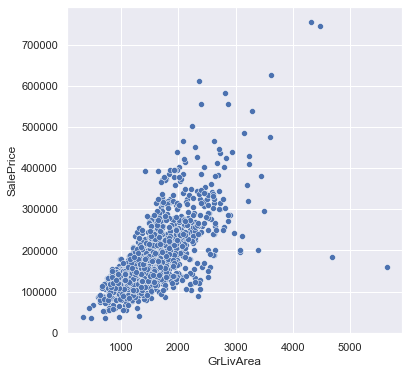

In [7]:
# figure'un şekli
rcParams['figure.figsize'] = (6.0, 6.0) 

# seaborn ile görselleştirme
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train)

plt.show()

In [8]:
# outlier atmadan önce şekil

train.shape

(1460, 81)

In [9]:
# şimdi outlier'ları atalım

train = train.drop(train[(train['GrLivArea']>3200)].index).reset_index(drop=True)

In [10]:
# outlier attıktan sonra şekil

train.shape

(1447, 81)

In [11]:
# outlier atılmış hali ile test datayı birleştirelim

all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'], test.loc[:,'MSSubClass':'SaleCondition']))

In [12]:
all_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


#### 2. Numerik'leri String Yapma (normalde String olması gerekenler için)

Her ne kadar "MSSubClass", "OverallCond", "YrSold" ve "MoSold" sütunları sayısal olsalar da bu sütunlar aslında sayısal bir büyüklük göstermez. 

Dolayısı ile onları kategorik yapmamız lazım.

In [13]:
all_data['YrSold']

0       2008
1       2007
2       2008
3       2006
4       2008
        ... 
1454    2006
1455    2006
1456    2006
1457    2006
1458    2006
Name: YrSold, Length: 2906, dtype: int64

In [14]:
# tür dönüşümü yapalım

all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

#### 3. Kategorik Sütunları Encode Etme

Bütün kategorik değişkenleri encode edeceğiz. (LabelEncoder ile)

In [15]:
from sklearn.preprocessing import LabelEncoder

In [16]:
# encode edilecek sütunlar

cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

In [17]:
# döngü ile bütün sütunları encode et

for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

In [18]:
# bütun sütunları görelim

all_data.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [19]:
# OneHotEncoder öncesi datanın şekli

all_data.shape

(2906, 79)

In [20]:
# şimdi one hot encoder yapabiliriz -> get_dummies()

all_data = pd.get_dummies(all_data)

In [21]:
# OneHotEncoder sonrası datanın şekli

all_data.shape

(2906, 219)

In [22]:
# yeni sütunları görelim

all_data.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape',
       'LandSlope', 'OverallQual', 'OverallCond', 'YearBuilt',
       ...
       'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=219)

#### 4. Normilazyon

Hedef değişkeninin grafiğine bakarsak sağa doğru kuyruk yaptığını kolayca görebiliriz.

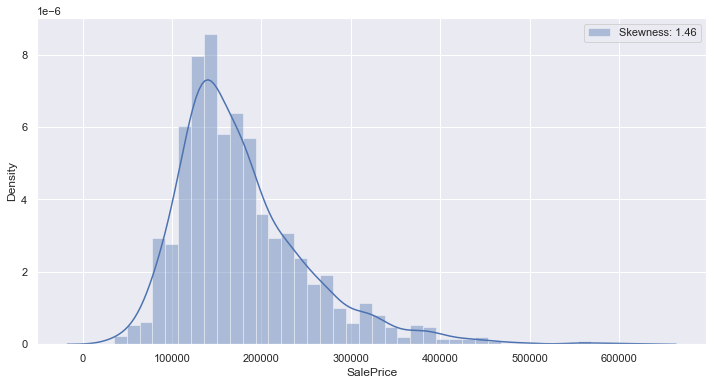

In [23]:
# scipy'in skew fonksiyonu bize skew yani kuyruk değerini verir
from scipy.stats import skew

# "SalePrice" için histogram

rcParams['figure.figsize'] = (12.0, 6.0) # şeklin boyutu

g = sns.distplot(train["SalePrice"], label="Skewness: %.2f"%(train["SalePrice"].skew()))

g = g.legend(loc="best")

plt.show()

Regresyon modelleri genel olarak normal dağılmış veriler üzerinde iyi sonuçlar verir.

Hedef değişkenini (y) bu hali ile kullanırsak çok sağlıklı sonuçlar elde edemeyiz.

(Regresyon için geçerli tabi bu.)

Log Transform yaparak datayı normalize edelim.

**Önemli:**

Sağa kuyruk yapan datalarda, Log Transform uygulayarak veriyi normal dağılıma uygun hale getirebilirsiniz.

(Ama sola kuyruk yapan datalarda bu çalışmaz.)

https://numpy.org/doc/stable/reference/generated/numpy.log1p.html

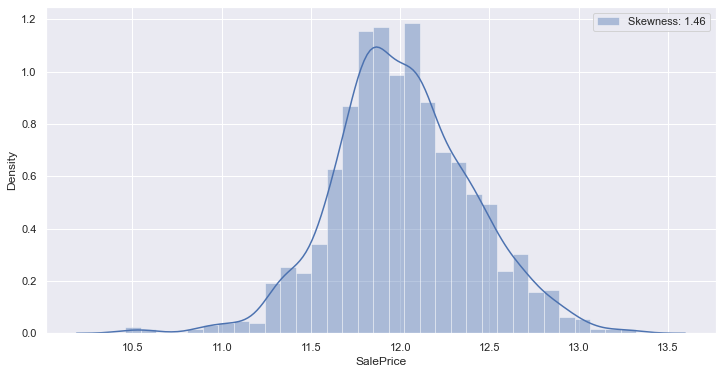

In [24]:
normalizedSalePrice = np.log1p(train["SalePrice"])

# "SalePrice" için histogram

rcParams['figure.figsize'] = (12.0, 6.0) # şeklin boyutu

g = sns.distplot(normalizedSalePrice, label="Skewness: %.2f"%(train["SalePrice"].skew()))

g = g.legend(loc="best")

plt.show()

Gördüğünüz gibi normalizedSalePrice kullanarak Nomal Dağılıma benzer bir sonuç elde ettik.

Şimdi SalePrice yerine log transform edilmiş halini yazabiliriz:

In [25]:
train["SalePrice"] = np.log1p(train["SalePrice"])

#### 5. Eksik Verileri Yönetme

Eksik veri var mı diye kontrol edeceğiz ve varsa ortalama (mean) yöntemi ile dolduracağız.

In [26]:
# eksik veri var mı

all_data.isnull().any().any()

True

In [27]:
# NA olan değerleri mean ile dolduralım

all_data = all_data.fillna(all_data.mean())

In [28]:
# eksik veri var mı

all_data.isnull().any().any()

False

#### 6. Model Matrisleri

In [29]:
# sklearn için matrisleri yaratlım

X_train = all_data[:train.shape[0]]

X_test = all_data[train.shape[0]:]

y = train.SalePrice

In [30]:
X_train.head()

,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,10,65.0,8450,1,2,3,0,7,4,2003,...,0,0,0,1,0,0,0,0,1,0
1,5,80.0,9600,1,2,3,0,6,7,1976,...,0,0,0,1,0,0,0,0,1,0
2,10,68.0,11250,1,2,0,0,7,4,2001,...,0,0,0,1,0,0,0,0,1,0
3,11,60.0,9550,1,2,0,0,7,4,1915,...,0,0,0,1,1,0,0,0,0,0
4,10,84.0,14260,1,2,0,0,8,4,2000,...,0,0,0,1,0,0,0,0,1,0


In [31]:
X_train.shape

(1447, 219)

---

## Lineer Regresyon

Önce klasik bir Lineer Regresyon modeli kuracağız.

Modelimizin performansını ölçmek için Root Mean Squared Error (RMSE) kullanacağız ve bunun için k-fold cross validation uygulayacağız.

In [32]:
from sklearn.model_selection import cross_val_score

In [33]:
# k-fold cross validation kullanarak RMSE hesapla

def rmse_cv(model, cv=5):
    rmse = np.sqrt(-cross_val_score(model, X_train, y, scoring='neg_mean_squared_error', cv=cv))
    return rmse
    

Şimdi Lineer Regresyon vererek fonksiyonumuzu çalıştıralım:

In [34]:
from sklearn.linear_model import LinearRegression

# lineer modeli yarat
linearModel = LinearRegression()

# rmse için fonksiyon çağır
rmse = rmse_cv(linearModel)

# sonucu yazdır
print("RMSE Ortalaması: {}, std: {}".format(rmse.mean(), rmse.std()))

RMSE Ortalaması: 0.12590152894768136, std: 0.012157159224612227


Şimdi modelimizi fit edip katsayılara bakalım.

In [35]:
# fit linear model
linearModel.fit(X_train, y)

LinearRegression()

Toplamda 219 adet katsayı olması lazım (219 değişken var çünkü).

In [36]:
# katsayılar

weights = linearModel.coef_

print(weights)

[ 1.63702343e-04  5.45013638e-04  1.97472332e-06  7.88496776e-02
 -9.14286913e-03  1.73168069e-03  9.03847864e-05  4.25411998e-02
  3.87449997e-02  1.90975918e-03  6.88471877e-04  2.05964569e-05
 -2.81349215e-03  1.02943789e-02 -1.03580636e-02  6.75256675e-03
 -3.86398162e-03 -8.68334435e-04  6.79803808e-05  2.22575553e-03
  2.88641172e-05 -8.17684592e-06  8.86676475e-05 -7.23632746e-03
  6.27017954e-02  8.25020905e-05  5.57499392e-05  4.82913643e-05
  1.86543252e-04  2.83355741e-02  1.09235245e-02  2.06708478e-02
  1.78802015e-02 -3.86856693e-03 -4.63594164e-02 -1.33853323e-02
  6.06947275e-03  1.79092492e-02  1.48336771e-02 -2.57647778e-03
 -1.36000429e-04 -3.17492238e-03  2.29096432e-02  9.16562145e-05
  4.91523819e-03  3.59561883e-03  1.11224912e-02  1.01848587e-04
  1.01042734e-04  1.33077820e-04  1.56690522e-04  2.74354541e-04
  6.23113459e-04  1.60833953e-01  4.00307382e-03 -7.85991257e-06
  4.56539872e-04 -2.63818390e-03 -3.18798511e-01  1.05624467e-01
  8.48562783e-02  8.22465

In [37]:
weights.shape

(219,)

In [38]:
# en büyük değerli katsayıları alalım (mutlak değer)

coef = pd.Series(weights, index = X_train.columns)

# ilk 10 ve son 10 büyük katsayıyı alalım (important coefficients)
imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])

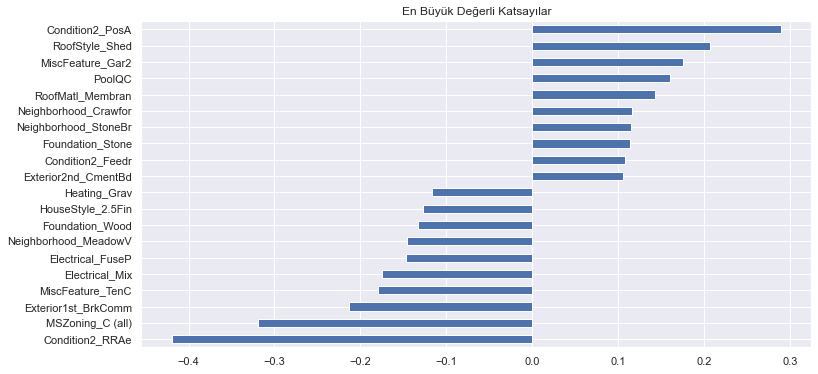

In [39]:
# şimdi bu katsayıları görelim

imp_coef.plot(kind = "barh")

plt.title("En Büyük Değerli Katsayılar")

plt.show()

https://pandas.pydata.org/pandas-docs/dev/reference/api/pandas.DataFrame.plot.barh.html

Gördüğünüz gibi katsayılardan bazıları büyük pozitif değerde bazıları büyük negatif değerde.

### Ridge Regression (L2-Regularization)

Şimdi aynı data üzerinde Ridge Regression yani üzerinde L2-Regularization uygulanmış Regresyon çalıştıralım.

Geleneksel olarak $\alpha = 0.1$ alınır. Biz de öyle alalım.

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

In [40]:
from sklearn.linear_model import Ridge

In [41]:
# alpha = 0.1 ile ridge regression modeli çalıştırıp RMSE hesaplayalım
ridgeModel = Ridge(alpha = 0.1)

# cross validation ile RMSE alalım
rmse = rmse_cv(ridgeModel)

print("RMSE Ortalaması: {}, std: {}".format(rmse.mean(), rmse.std()))

RMSE Ortalaması: 0.12418990183946899, std: 0.01158778239587258


Gördüğünüz gibi az da olsa bir iyileşme sağladık.

* Linear Regression -> RMSE = 0.1259
* Ridge Regression -> RMSE = 0.1241

Ama asıl önemli kazanım burada katsayıların değerleridir.

Daha küçük değerli katsayılar ve daha az varyans vardır. Dolayısı ile model daha iyi genellenebilir.

(Hatırlayın: Bias-Variance Trade-Off)

Şimdi Ridge Regression Modelini eğitelim ve katsayılara bakalım. ($\alpha$ değerimiz hala 0.1)

In [42]:
# fit linear model
ridgeModel.fit(X_train, y)

Ridge(alpha=0.1)

In [43]:
# en büyük değerli katsayıları alalım (mutlak değer)

coef_ridge = pd.Series(ridgeModel.coef_, index = X_train.columns)

# ilk 10 ve son 10 büyük katsayıyı alalım (important coefficients)
imp_coef_ridge = pd.concat([coef_ridge.sort_values().head(10), coef_ridge.sort_values().tail(10)])

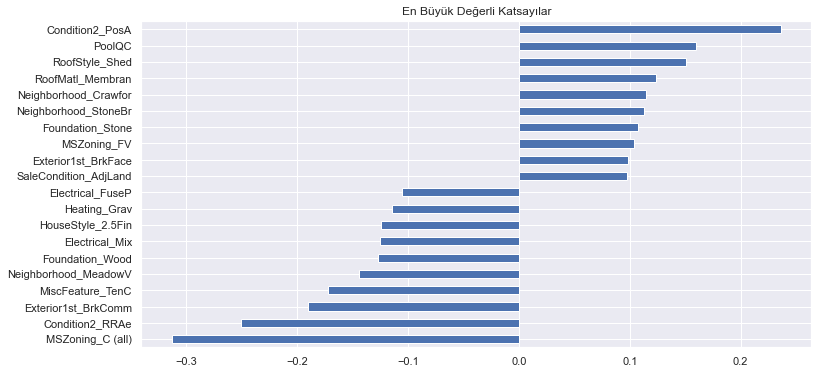

In [44]:
# şimdi bu katsayıları görelim

imp_coef_ridge.plot(kind = "barh")

plt.title("En Büyük Değerli Katsayılar")

plt.show()

Fakat bir sorun var:

Katsayılarımız hala çok büyük.

Demek ki $\alpha$ değerini tam ayarlayamadık. 

Zaten 0.1 olarak rasgele vermiştik.

$\alpha$ bir Hyperparameter. 

Demek ki doğru $\alpha$ değerini bulmak Hyperparameter Tuning yapmamız lazım.

Şimdi Cross Validation ile bir çok $\alpha$ değeri deneyip en iyisini bulalım.

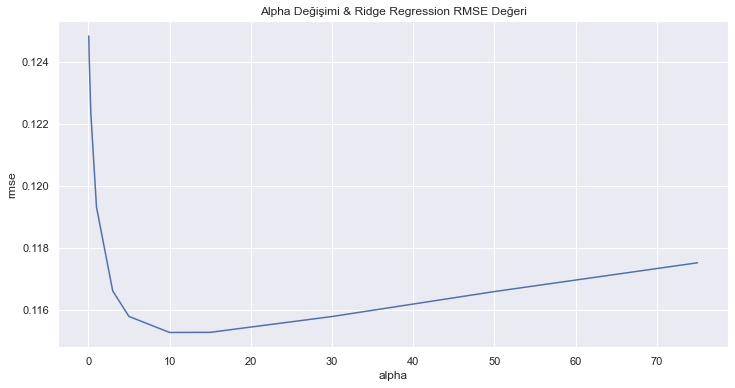

In [45]:
# farklı alpha değerleri için RMSE hesapla

alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]

cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas]

cv_ridge = pd.Series(cv_ridge, index = alphas)

# RMSE vs alpha grafiği
cv_ridge.plot(title = "Alpha Değişimi & Ridge Regression RMSE Değeri")

plt.xlabel("alpha")
plt.ylabel("rmse")

plt.show()

Görüldüğü gibi en uygun (optimum) $\alpha$ değeri 10 civarında.

Bakalım tam olarak kaçmış:

In [46]:
optimalRidgeAlpha = cv_ridge[cv_ridge == cv_ridge.min()].index.values[0]

print("Optimal Ridge Alpha Değeri: {}".format(optimalRidgeAlpha))

Optimal Ridge Alpha Değeri: 10.0


Şimdi $\alpha = 10.0$ ile tekrar deneylim Ridge Regression'ı.

In [47]:
# optimal alpha ile ridge regression modelin RMSE değerini bulalım
ridgeModel = Ridge(alpha = optimalRidgeAlpha)

rmse = rmse_cv(ridgeModel)

print("RMSE Ortalaması: {}, std: {}".format(rmse.mean(), rmse.std()))

RMSE Ortalaması: 0.11525687438039715, std: 0.007515749124597703


Şimdi tekrar fit edip bir daha bakalım katsayılara:

In [48]:
# fit linear model
ridgeModel.fit(X_train, y)

Ridge(alpha=10.0)

In [49]:
# en büyük değerli katsayıları alalım (mutlak değer)

coef_ridge = pd.Series(ridgeModel.coef_, index = X_train.columns)

# ilk 10 ve son 10 büyük katsayıyı alalım (important coefficients)
imp_coef_ridge = pd.concat([coef_ridge.sort_values().head(10), coef_ridge.sort_values().tail(10)])

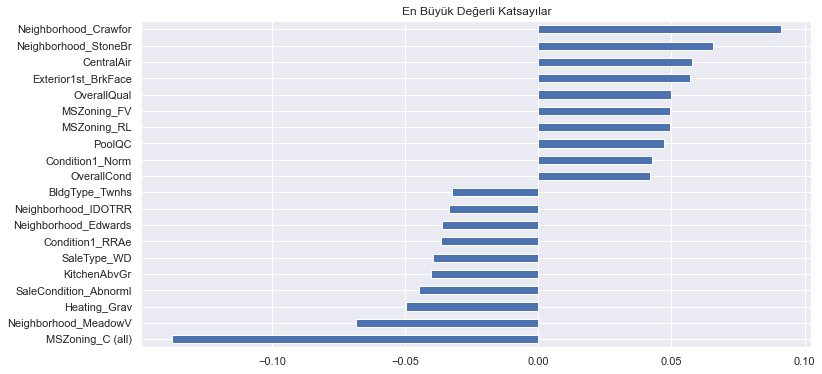

In [50]:
# şimdi bu katsayıları görelim

imp_coef_ridge.plot(kind = "barh")

plt.title("En Büyük Değerli Katsayılar")

plt.show()

Gördüğünüz gibi RMSE biraz daha iyileşti: 0.1152

Eğer seçili katsayıları Ridge Regression ve Linear Regression üzerinden aynı grafikte görürsek, çok açıkça görülecektir ki:
* Ridge Regression ile katsayı değerleri çok daha küçük olmuştur

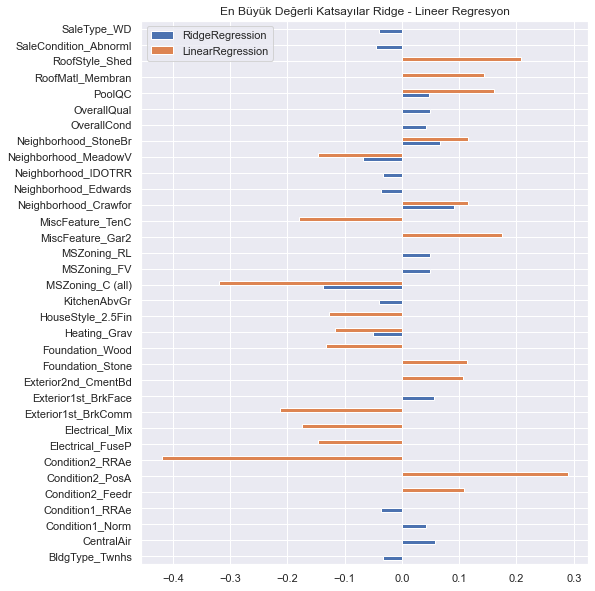

In [51]:
# en büyük değerli katsayılar
ridge_coef = pd.Series(ridgeModel.coef_, index = X_train.columns)
ridge_imp_coef = pd.concat([ridge_coef.sort_values().head(10), ridge_coef.sort_values().tail(10)])

rcParams['figure.figsize'] = (8.0, 10.0) # grafiğin boyutu

df = pd.DataFrame({ "RidgeRegression" : ridge_imp_coef, "LinearRegression" : imp_coef })

df.plot(kind = "barh")
plt.title("En Büyük Değerli Katsayılar Ridge - Lineer Regresyon")

plt.show()

### Lasso Regression (L1-Regularization)

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

Lasso için yine $\alpha = 0.1$ ile başlayalım.

In [52]:
from sklearn.linear_model import Lasso

In [53]:
# determine RMSE for lasso regression model with alpha = 0.1
lassoModel = Lasso(alpha = 0.1)
rmse = rmse_cv(lassoModel)
print("RMSE Ortalaması: {}, std: {}".format(rmse.mean(), rmse.std()))

RMSE Ortalaması: 0.16050445222133877, std: 0.00475273958022816


Bu alpha değeri ile Lasso en kötü RMSE veren model oldu.

Ama alpha değerini ayarlayarak yeniden bakalım.

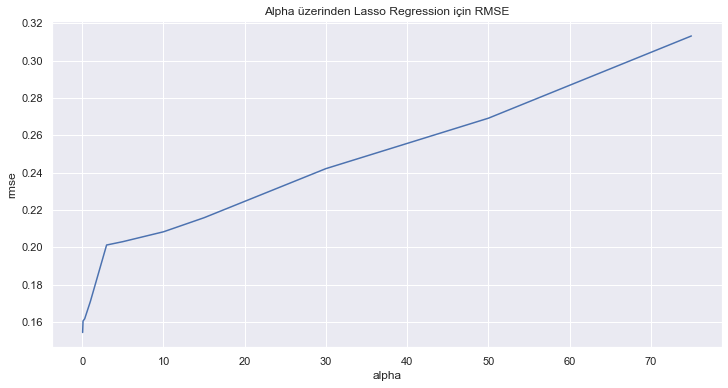

In [54]:
# Farklı alpha değerleri için RMSE hesapla

alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]

cv_lasso = [rmse_cv(Lasso(alpha = alpha)).mean() for alpha in alphas]
cv_lasso = pd.Series(cv_lasso, index = alphas)

# grafiğin boyutu
rcParams['figure.figsize'] = (12.0, 6.0)

# plot RMSE vs alpha
cv_lasso.plot(title = "Alpha üzerinden Lasso Regression için RMSE")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()

Burada bir sorun görüyoruz.

Teorik olarak RMSE'nin bazı alpha değerleri için azalıyor olmasını beklerdik.

Ama öyle olmadı.

Sebebi bizim verdiğimiz alpha değerlerinin çok uygun olmaması. (Verdiğimiz listede en uygun değer yok)

Alpa değerlerini manuel vermek yerine sklarn'ün LassoCV (Lasso Cross Validation) classını kullanarak en uygun alphayı bulabiliriz.

(Hyperparameter Tuning)

In [55]:
from sklearn.linear_model import LassoCV

# LassoCV ile en uygun alpha değerini bul
lassoModel = LassoCV(alphas = np.linspace(0.0002, 0.0022, 21), cv = 5).fit(X_train, y)
lassoModel.alpha_

optimalLassoAlpha = lassoModel.alpha_
print("Optimal lasso alpha: {}".format(optimalLassoAlpha))

Optimal lasso alpha: 0.0005


Bakın en uygun alpha değeri 0.0005 çıktı. Bu değer gerçekten de bizim listemizde yoktu.

Şimdi bu alpha ile tekrar Lasso çalıştıralım:

In [56]:
lassoModel = Lasso(alpha = optimalLassoAlpha)

rmse = rmse_cv(lassoModel)

print("RMSE Ortalaması: {}, std: {}".format(rmse.mean(), rmse.std()))

RMSE Ortalaması: 0.11297541732413333, std: 0.007183534409277972


Gördüğünüz gibi RMSE epey iyileşti.

Hatta şu anda en iyi RMSE, Lasso'da diyebiliriz:
* Linner Regresyon: RMSE = 0.1259
* Ridge: RMSE = 0.1152
* Lasso: RMSE = 0.1129

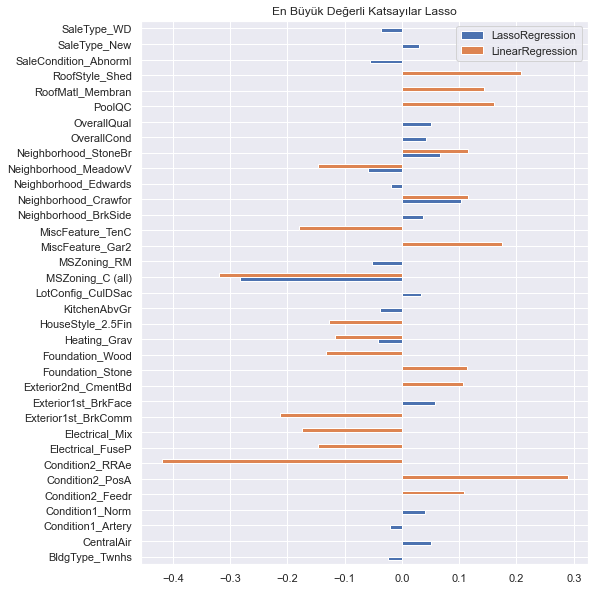

In [57]:
# fit lasso model
lassoModel.fit(X_train, y)

# en büyük değerli katsayılar
lasso_coef = pd.Series(lassoModel.coef_, index = X_train.columns)
lasso_imp_coef = pd.concat([lasso_coef.sort_values().head(10), lasso_coef.sort_values().tail(10)])

rcParams['figure.figsize'] = (8.0, 10.0)

df = pd.DataFrame({ "LassoRegression" : lasso_imp_coef, "LinearRegression" : imp_coef })

df.plot(kind = "barh")
plt.title("En Büyük Değerli Katsayılar Lasso")
plt.show()

Gördüğünüz gibi Lasso'da da katsayıların çoğu sıfır (0) değerli oldu.

Bu aslında Regularizasyon'un amacıdır ve bunu gayet net olarak gördük.

**Soru:**

Peki katsayıların sıfır olması neden önemlidir?

**Cevap:**

Sıfır olan bir katsayı, o katsayının işaret ettiği değişkenin sonuç için önemsiz olduğunu anlatır.

Dolayısı ile değişken sayısı azalmış olur ve modelimiz sadeleşir.

Sadelik ML için iyi bir şeydir. Varyansınız azalır. Daha iyi genelleme yapabilirsiniz. (Bias'ınız da artar)

### Ridge ve Lasso Farkı

Hem Ridge hem de Lasso birer Regülarizasyon Tekniğidir ve amaçları Lineer Regresyon'a bir ceza terimi ekleyip katsayıların aşırı büyümesini engellemektir.

Fakat biraz farklı çalışırlar:
* Ridge, yüksek katsayı değerlerini cezalandırır ama onları sıfır yapmaya zorlamaz
* Lasso ise olabildiğince fazla katsayıyı sıfır yapmaya zorlar

Ridge ve Lasso'da Sıfır olan katsayı adetlerini görelim:

In [61]:
ridge_coef = pd.Series(ridgeModel.coef_, index = X_train.columns)
print('Sıfır Olmayan Katsayı Adedi - Ridge:', sum(ridge_coef != 0))
print('Sıfır Katsayı Adedi - Ridge:', sum(ridge_coef == 0))

Sıfır Olmayan Katsayı Adedi - Ridge: 219
Sıfır Katsayı Adedi - Ridge: 0


In [60]:
lasso_coef = pd.Series(lassoModel.coef_, index = X_train.columns)
print('Sıfır Olmayan Katsayı Adedi - Lasso:', sum(lasso_coef != 0))
print('Sıfır Katsayı Adedi - Lasso:', sum(lasso_coef == 0))

Sıfır Olmayan Katsayı Adedi - Lasso: 96
Sıfır Katsayı Adedi - Lasso: 123


Görüldüğü gibi Lasso'da tam olarak 123 adet değişken sıfır değeri aldı.

Yani aslında bunların çok da önemli olmadıkları ortaya çıkmış oldu.

Dolayısı ile Lasso aslında bir yerde Feature Elimination (Değişken Azaltma) işini yapmış oldu.

Lasso'nun çok sık kıllanılma yerlerinden biri bu Feature Elimination işleridir.